# Extract stop locations from CTA data

 stops.txt - list of stop locations for bus and train, also includes parent station info for trains

 stop_id, latitude and longitude columns. Create a dictionary -> key: stop_id, value: (latitude, longitude)

 Location type. Valid options are:

0 (or blank) - Stop (or Platform). A location where passengers board or disembark from a transit vehicle. Is called a platform when defined within a parent_station.

1 - Station. A physical structure or area that contains one or more platform.

2 - Entrance/Exit. A location where passengers can enter or exit a station from the street. If an entrance/exit belongs to multiple stations, it may be linked by pathways to both, but the data provider must pick one of them as parent.

3 - Generic Node. A location within a station, not matching any other location_type, that may be used to link together pathways define in pathways.txt.

4 - Boarding Area. A specific location on a platform, where passengers can board and/or alight vehicles.


Latitude and longtitude of the location.

For stops/platforms (location_type=0) and boarding area (location_type=4), the coordinates must be the ones of the bus pole — if exists — and otherwise of where the travelers are boarding the vehicle (on the sidewalk or the platform, and not on the roadway or the track where the vehicle stops).

Conditionally Required:
- Required for locations which are stops (location_type=0), stations (location_type=1) or entrances/exits (location_type=2).
- Optional for locations which are generic nodes (location_type=3) or boarding areas (location_type=4).

In [ ]:
import pandas as pd
from data_utils import DataHandler
import plotly.express as px
import random
import networkx as nx
import osmnx as ox
import peartree as pt

handler = DataHandler()
chicago = handler.load_chicago()
graph = handler.load_graph()

In [2]:
# Extracting the transit graph from Google Transit data by using peartree.
feed = pt.get_representative_feed('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit.zip')

In [ ]:
# Pick a target time to extract as a graph. We do peak an hour from 7 to 11 in the morning.
start = 7 * 60 * 60
end = 11 * 60 * 60
%time G_transit = pt.load_feed_as_graph(feed, start, end)

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

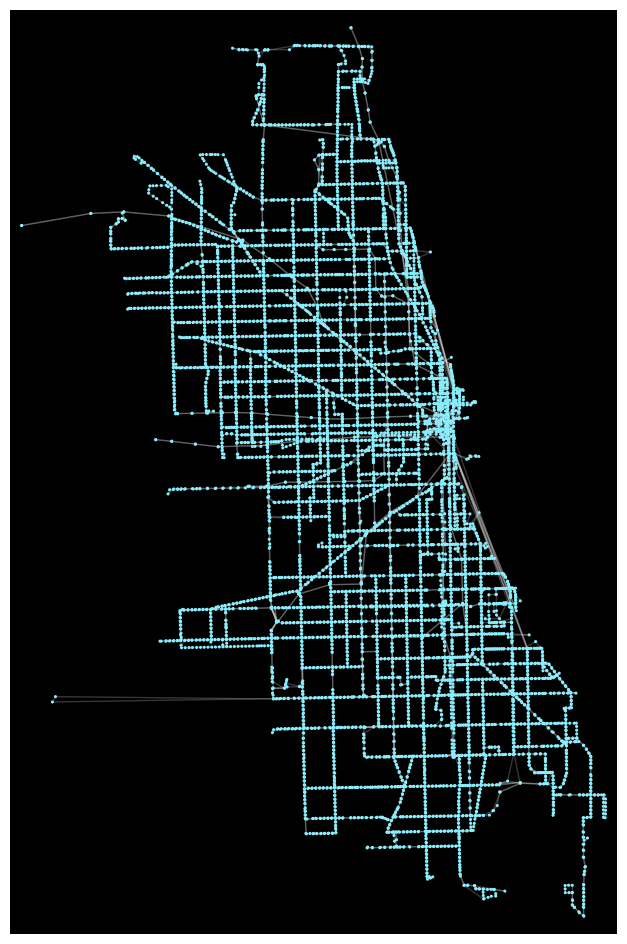

In [5]:
pt.plot.generate_plot(G_transit)

In [2]:
# OSMnx retrieves place boundaries of city from Nominatim API, retrieves the walkable street network data within those boundaries from the Overpass API, 
# constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. 

G_walk = ox.graph_from_place("Chicago, Illinois, USA", network_type="walk")

In [4]:
G_walk

In [5]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_walk)

In [8]:
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
20217109,41.889145,-87.622517,1,NaN,NaN,POINT (-87.62252 41.88914)
20217442,41.879062,-87.637740,1,NaN,NaN,POINT (-87.63774 41.87906)
26098103,41.866556,-87.619221,3,NaN,NaN,POINT (-87.61922 41.86656)
26098113,41.880924,-87.617244,5,traffic_signals,NaN,POINT (-87.61724 41.88092)
26099529,41.925745,-87.633621,4,traffic_signals,NaN,POINT (-87.63362 41.92575)


In [7]:
gdf_edges.head()

osmid     highway  \
u        v           key                                                  
20217109 11810091969 0                           1271789229     footway   
20217442 6423774545  0                           1178187730     footway   
26098103 705003083   0               [377665857, 294583211]       trunk   
         5911252695  0               [902555113, 626135475]  trunk_link   
         11940351897 0    [902555112, 518376771, 294583212]       trunk   

                          oneway reversed   length   lanes    ref  \
u        v           key                                            
20217109 11810091969 0     False    False    0.598     NaN    NaN   
20217442 6423774545  0     False     True    2.065     NaN    NaN   
26098103 705003083   0     False     True  340.799       4  US 41   
         5911252695  0     False    False  133.618       2    NaN   
         11940351897 0     False    False  613.802  [6, 4]  US 41   

                                                    name maxspeed  \
u        v           key                                            
20217109 11810091969 0                               NaN      NaN   
20217442 6423774545  0                               NaN      NaN   
26098103 705003083   0    South DuSable Lake Shore Drive   40 mph   
         5911252695  0                               NaN      NaN   
         11940351897 0    South DuSable Lake Shore Drive   40 mph   

                                                                   geometry  \
u        v           key                                                      
20217109 11810091969 0    LINESTRING (-87.62252 41.88914, -87.62252 41.8...   
20217442 6423774545  0    LINESTRING (-87.63774 41.87906, -87.63772 41.8...   
26098103 705003083   0    LINESTRING (-87.61922 41.86656, -87.61924 41.8...   
         5911252695  0    LINESTRING (-87.61922 41.86656, -87.61929 41.8...   
         11940351897 0    LINESTRING (-87.61922 41.86656, -87.61917 41.8...   

                         bridge width service access tunnel junction area  
u        v           key                                                   
20217109 11810091969 0      NaN   NaN     NaN    NaN    NaN      NaN  NaN  
20217442 6423774545  0      NaN   NaN     NaN    NaN    NaN      NaN  NaN  
26098103 705003083   0      NaN   NaN     NaN    NaN    NaN      NaN  NaN  
         5911252695  0      NaN   NaN     NaN    NaN    NaN      NaN  NaN  
         11940351897 0      NaN   NaN     NaN    NaN    NaN      NaN  NaN

In [9]:
print(gdf_edges.dtypes)

osmid         object
highway       object
oneway          bool
reversed      object
length       float64
lanes         object
ref           object
name          object
maxspeed      object
geometry    geometry
bridge        object
width         object
service       object
access        object
tunnel        object
junction      object
area          object
dtype: object


In [ ]:
import geopandas as gpd

# Define the file paths for the shapefiles
nodes_shapefile = "nodes.shp"
edges_shapefile = "edges.shp"

# Save the nodes and edges GeoDataFrames as shapefiles
gdf_nodes.to_file(nodes_shapefile, driver='ESRI Shapefile')
gdf_edges.to_file(edges_shapefile, driver='ESRI Shapefile')

In [5]:
edge = random.choice(list(G_walk.edges))
edge

(10119828628, 253960274, 0)

In [ ]:
# Visually inspect (takes a minute or two)
ox.plot_graph(G_walk)

In [6]:
# Note the edge structure of the peartree graph
print(list(G_transit.edges(data=True))[0])
# ('9E6AA_10', '9E6AA_5314', {'length': 71.0, 'mode': 'transit'})

# ...and that of the OSMnx graph
print('OSMNX GRAPH')
print(list(G_walk.edges(data=True))[0])
# (115998720,
#  116012585,
#  {'highway': 'residential',
#   'length': 96.733,
#   'name': 'Lane Street',
#   'oneway': False,
#   'osmid': 12703799})

('FQQ8F_1', 'FQQ8F_2', {'length': 73.89473684210526, 'mode': 'transit'})
OSMNX GRAPH
(20217109, 11810091969, {'osmid': 1271789229, 'highway': 'footway', 'oneway': False, 'reversed': False, 'length': 0.598})


In [7]:
# Since peartree represents edge length (that is the impedance value associated with the edge) in seconds; 
# we need to convert the edge values that are in meters into seconds.

walk_speed = 4.5  # about 3 miles per hour

# Make a copy of the graph in case we make a mistake
G_walk_adj = G_walk.copy()

# Iterate through and convert lengths to seconds
for from_node, to_node, edge in G_walk_adj.edges(data=True):
    orig_len = edge['length']
    
    # Note that this is a MultiDiGraph so there could
    # be multiple indices here, I naively assume this is not
    # the case
    G_walk_adj[from_node][to_node][0]['orig_length'] = orig_len

    # Conversion of walk speed and into seconds from meters
    kmph = (orig_len / 1000) / walk_speed
    in_seconds = kmph * 60 * 60
    G_walk_adj[from_node][to_node][0]['length'] = in_seconds
    
    # And state the mode, too
    G_walk_adj[from_node][to_node][0]['mode'] = 'walk'

In [10]:
# Ensure that we now have both length values (and
# thus an updated edge schema)
list(G_walk_adj.edges(data=True))[0]

(20217109,
 11810091969,
 {'osmid': 1271789229,
  'highway': 'footway',
  'oneway': False,
  'reversed': False,
  'length': 0.47839999999999994,
  'orig_length': 0.598,
  'mode': 'walk'})

In [ ]:
# Now that we have a formatted walk network
# it should be easy to reload the peartree graph
# and stack it on the walk network
start = 7 * 60 * 60
end = 9 * 60 * 60

# Note this will be a little slow - an optimization here would be
# to have coalesced the walk network
%time G = pt.load_feed_as_graph(feed, start, end, existing_graph=G_walk_adj)

In [9]:
# This is an issue that needs cleaning up
# some nodes that should have been
# cleaned out remain
print('All nodes', len(G.nodes()))
bad_ns = [i for i, n in G.nodes(data=True) if 'x' not in n]
print('Bad nodes count', len(bad_ns))

for bad_n in bad_ns:
    # Make sure they do not conenct to anything
    if len(G[bad_n]) > 0:
        # This should not happen
        print(bad_n)

    else:
        # So just drop them
        G.remove_node(bad_n)

All nodes 339319
Bad nodes count 66506


(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

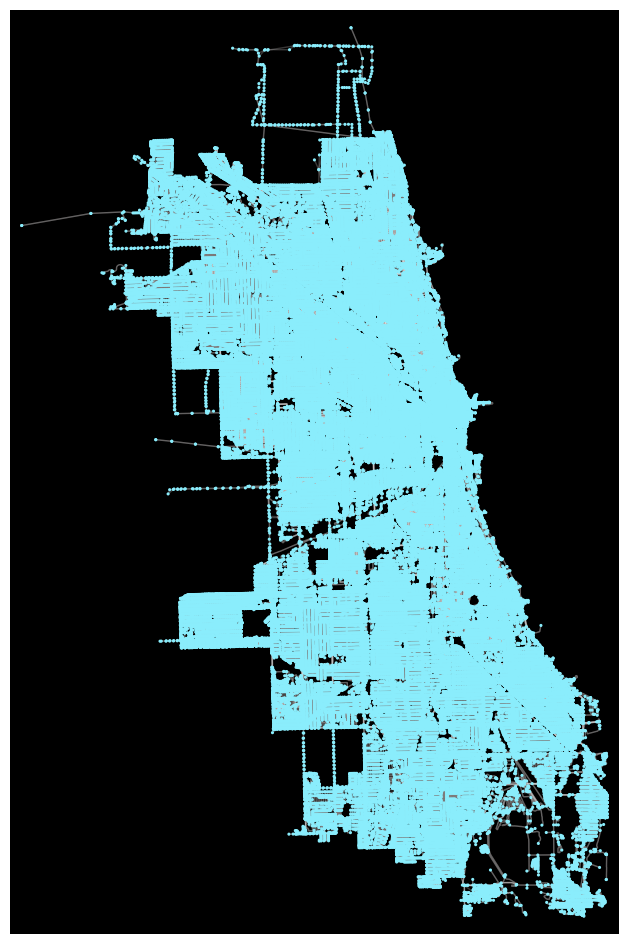

In [13]:
pt.plot.generate_plot(G)

In [14]:
# Save the merged graph
import pickle
import gzip 

file_path = '/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/prepared_data/network.pkl.gz'
with gzip.open(file_path, 'wb') as file:
                pickle.dump(G, file)

travel time -> key: (node i, facility j), value: travel time from node i to facility j

Each facility is considered as the center of its container Census block. 


Add locations as attributes with names C_X, C_Y

make stop attributes and assign True for stops in the graph.

create ids following the last id in the graph

stop_id 
stop_name
location_type
parent_station

Centroid -> Population centroid

In [10]:
node = random.choice(list(graph.nodes))
graph.nodes[node]

{'boundary_node': False,
 'area': 8.637965000019385e-07,
 'STATEFP20': '17',
 'COUNTYFP20': '031',
 'TRACTCE20': '260500',
 'BLOCKCE20': '1024',
 'GEOID20': '170312605001024',
 'ALAND20': 7964,
 'C_X': -87.73679434672519,
 'C_Y': 41.8753538881982,
 'pop': 43,
 'phc': 0,
 'real_phc': False}

In [2]:
stops = pd.read_csv('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit/stops.txt')
#stops.head()

In [12]:
len(stops)

11166

In [ ]:
stops.head()

In [ ]:
i = max(node for node in graph.nodes) + 1
i + len(stops)

In [ ]:
matrix(locations: List[List[float]], profile: str, sources: Optional[Union[List[int], Tuple[int]]] = None, destinations: Optional[Union[List[int], Tuple[int]]] = None, avoid: Optional[List[str]] = None, language: Optional[str] = None, region: Optional[str] = None, units: Optional[str] = None, arrival_time: Optional[int] = None, departure_time: Optional[int] = None, traffic_model: Optional[str] = None, transit_mode: Optional[Union[List[str], Tuple[str]]] = None, transit_routing_preference: Optional[str] = None, dry_run: Optional[bool] = None)

In [4]:
# Numeric color map
color_map = {
   0: "red",  # platform
   1: "blue", # station
   2: "green", # entrance/exit
   3: "gray",  # generic node
   4: "yellow",   # boarding area
}

# Map 'location_type' to colors
stops['color'] = stops['location_type'].map(color_map)

In [5]:
count = {'platform':0, 'station':0, 'exit':0, 'generic':0, 'boarding area':0}

for index, row in stops.iterrows():
    if row['location_type'] == 0:
        count['platform'] +=1
    if row['location_type'] == 1:
        count['station'] +=1
    if row['location_type'] == 2:
        count['exit'] +=1
    if row['location_type'] == 3:
        count['generic'] +=1
    if row['location_type'] == 4:
        count['boarding area'] +=1

In [6]:
count

{'platform': 11009,
 'station': 141,
 'exit': 16,
 'generic': 0,
 'boarding area': 0}

# CTA Data Information

agency.txt - basic agency information

routes.txt - route list with unique identifiers

trips.txt - has information about each trip taken by a CTA vehicle

stop_times.txt - scheduled arrival/departure times for each stop on each trip

calendar.txt - defines which service IDs operate on which days

calendar_dates.txt - has exceptions to calendar (such as a holiday when a Sunday schedule is operated)

shapes.txt - defines how to draw a route line on a map

frequencies.txt - defines headways when trips aren't specifically scheduled, but sent as-needed (such as service that follows a major event)

transfers.txt - has additional information to guide trip planners into identifying two stops as a transfer point and how much extra time to give people to transfer between services

# We need stop_times, routes, stops and trips. We first identify and store stops as attributes of nodes.

- The goal is to assign a travel time to each edge. We will use STOP_TIMES.TXT for that. Stop times are identified by trip id's. 

- STOP TIMES: We will parse ARRIVAL_TIME at STOPS for each TRIP_ID. Note that STOP_TIMES and TRIP_ID are directly related. 
    
- Then, we will calculate the travel time between consecutive stops by substracting the arrival times at the stops.

- Determine the nodes containing a stop in it (R-tree spatial indexing using STOP LOCATIONS). Assign an attribute called 'stop' = [stop_id] to each node. 
    
- If there is no stop in the Census block corresponding to a node, then 'stop' = [], empty list. For more than one stop, the list will have more than one stop_id.

# Stops are identified and saved. Now, we need to see the trips between identified stops.

- There might be two different trips between two nodes. In such case, each vehicle will have different travel time to travel through the edge connecting the nodes.

-  We assign multiple edges such that each edge represent a trip between two nodes. So, the construction of directed graph depends on trips.

-  Apply item 3 for a certain moment? We should take a normal distribution of daily travel times of each trip. 

- Should we consider waiting time? Dijkstra's algorithm may implicitly change many trips when determining the minimum shortest path connecting two nodes. 

- Which day should we consider? Monday? CALENDAR.TXT


- Create a class of network graph. 

- Assign stop = TRUE or FALSE to each node.  

- PHCs are included in travel time calculations. They are considered as the center of their blocks. But we define nodes for stops and include them in the travel time calculations.

In [ ]:
import pandas

f = pandas.read_csv('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit/calendar.txt')

In [7]:
import pandas

calendar = pandas.read_csv('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit/calendar.txt')

In [8]:
calendar.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,66201,1,1,1,1,1,0,0,20240130,20240331
1,66202,1,1,1,1,0,0,0,20240130,20240331
2,66203,0,1,1,1,1,0,0,20240130,20240331
3,66204,0,1,1,1,1,0,0,20240130,20240331
4,66205,0,0,0,0,1,0,0,20240130,20240331


In [9]:
frequencies = pandas.read_csv('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit/frequencies.txt')
frequencies.head()

,trip_id,start_time,end_time,headway_secs


In [10]:
routes = pandas.read_csv('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit/routes.txt')
routes.head()

,route_id,route_short_name,route_long_name,route_type,route_url,route_color,route_text_color
0,1,1,Bronzeville/Union Station,3,http://www.transitchicago.com/bus/1/,565a5c,ffffff
1,2,2,Hyde Park Express,3,http://www.transitchicago.com/bus/2/,b71234,ffffff
2,3,3,King Drive,3,http://www.transitchicago.com/bus/3/,565a5c,ffffff
3,4,4,Cottage Grove,3,http://www.transitchicago.com/bus/4/,565a5c,ffffff
4,X4,X4,Cottage Grove Express,3,http://www.transitchicago.com/bus/X4/,b71234,ffffff


In [11]:
# defines how to draw a route line on a map
shapes = pandas.read_csv('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit/shapes.txt')
shapes.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,66200095,41.911304,-87.631222,1,0
1,66200095,41.911304,-87.631222,2,13
2,66200095,41.911270,-87.631234,3,24
3,66200095,41.911250,-87.631264,4,33
4,66200095,41.911237,-87.631294,5,52


In [12]:
stop_times = pd.read_csv('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit/stop_times.txt')
stop_times.head()

# trip_id: 	Identifies a trip.

# arrival_time: Arrival time at a specific stop for a specific trip on a route. If there are not separate times for arrival and departure at a stop,
#               enter the same value for arrival_time and departure_time. Scheduled stops where the vehicle strictly adheres to the specified arrival and
#               departure times are timepoints. If this stop is not a timepoint, it is recommended to provide an estimated or interpolated time. If this is not available, arrival_time can be left empty.

# stop_id: Identifies the serviced stop. All stops serviced during a trip must have a record in stop_times.txt. Referenced locations must be stops, not stations or station entrances.
#          A stop may be serviced multiple times in the same trip, and multiple trips and routes may service the same stop.

# stop_sequence: Order of stops for a particular trip. The values must increase along the trip but do not need to be consecutive.
#                Example: The first location on the trip could have a stop_sequence=1, the second location on the trip could have a stop_sequence=23, the third location could have a stop_sequence=40, and so on.

# pickup_type: Indicates pickup method. Valid options are:
#              0 or empty - Regularly scheduled pickup.
#              1 - No pickup available.
#              2 - Must phone agency to arrange pickup.
#              3 - Must coordinate with driver to arrange pickup.

# drop_off_type: 0 or empty - Regularly scheduled drop off.

# shape_dist_traveled: Actual distance traveled along the associated shape, from the first stop to the stop specified in this record. This field specifies how much of the shape to draw between any two stops during a trip.
#                      Must be in the same units used in shapes.txt. Values used for shape_dist_traveled must increase along with stop_sequence; they cannot be used to show reverse travel along a route.

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled
0,82248584890,05:43:30,05:43:30,30205,6,Loop,0,34873
1,82248584890,05:46:00,05:46:00,30215,7,Loop,0,40317
2,81248584890,05:46:00,05:46:00,30215,7,Loop,0,40317
3,82248584890,05:51:00,05:51:00,30080,8,Loop,0,51245
4,81248584890,05:51:00,05:51:00,30080,8,Loop,0,51245


In [13]:
transfers = pd.read_csv('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit/transfers.txt')
transfers.head()

# from_stop_id: Identifies a stop or station where a connection between routes begins. If this field refers to a station, the transfer rule applies to all its child stops.
# to_stop_id: Identifies a stop or station where a connection between routes ends. If this field refers to a station, the transfer rule applies to all child stops.
# transfer_type: Indicates the type of connection for the specified (from_stop_id, to_stop_id) pair.
#    0 or empty - Recommended transfer point between routes.
#    1 - Timed transfer point between two routes. The departing vehicle is expected to wait for the arriving one and leave sufficient time for a rider to transfer between routes.
#    2 - Transfer requires a minimum amount of time between arrival and departure to ensure a connection. The time required to transfer is specified by min_transfer_time.
#    3 - Transfers aren't possible between routes at the location.
#    4 - Passengers can stay onboard the same vehicle to transfer from one trip to another (an "in-seat transfer").
#    5 - In-seat transfers aren't allowed between sequential trips. The passenger must alight from the vehicle and re-board.

,from_stop_id,to_stop_id,transfer_type
0,30173,30173,0
1,30173,30175,0
2,30256,30258,0
3,30257,30258,0
4,30236,30233,0


In [14]:
trips = pd.read_csv('/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/google_transit/trips.txt')
trips.head()

# route_id: Identifies a route.
# service_id: Identifies a set of dates when service is available for one or more routes.
# trip_id: Identifies a trip.
# direction_id: Indicates the direction of travel for a trip. 0 - Travel in one direction (e.g. outbound travel). 1 - Travel in the opposite direction (e.g. inbound travel).
# block_id: Identifies the block to which the trip belongs. A block consists of a single trip or many sequential trips made using the same vehicle,
#   defined by shared service days and block_id. A block_id can have trips with different service days, making distinct blocks.
# shape_id: Identifies a geospatial shape that describes the vehicle travel path for a trip.

,route_id,service_id,trip_id,direction_id,block_id,shape_id,direction,wheelchair_accessible,schd_trip_id
0,X49,66201,6620042528020,1,662000001341,66207873,North,1,42528020
1,X49,66201,6620043108020,1,662000002919,66207873,North,1,43108020
2,X49,66201,6620043771020,1,662000001342,66207873,North,1,43771020
3,X49,66201,6620044790020,1,662000003037,66207873,North,1,44790020
4,X9,66201,6620000276020,1,662000002882,66208470,North,1,276020


In [ ]:
# Merge 'stop_times' with 'trips' to include 'route_id' and 'direction_id'
stop_times = stop_times.merge(trips[['trip_id', 'route_id', 'direction_id']], on='trip_id')

# Now, 'stop_times' DataFrame includes stop information, trip information, and direction


In [4]:
from pyrosm.data import sources

# Print available source categories
sources.available.keys()

dict_keys(['africa', 'antarctica', 'asia', 'australia_oceania', 'central_america', 'europe', 'north_america', 'south_america', 'cities', 'subregions'])

In [17]:
import pyrosm

# Get filepath to test PBF dataset
fp = pyrosm.get_data("test_pbf")
print("Filepath to test data:", fp)

# Initialize the OSM object 
osm = pyrosm.OSM(fp)

# See the type
print("Type of 'osm' instance: ", type(osm))


{'name': 'illinois-latest.osm.pbf',
 'url': 'http://download.geofabrik.de/north-america/us/illinois-latest.osm.pbf'}

In [ ]:
from pyrosm import OSM
from pyrosm import get_data
import matplotlib

# Initialize the OSM parser object
osm = OSM("/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/initial_data/street.pbf")

# Read all roads: 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
# =======================
drive_net = osm.get_network(network_type="all")
drive_net.plot()

In [27]:
drive_net.head(2)

,access,area,bicycle,bicycle_road,bridge,busway,cycleway,foot,footway,highway,...,tunnel,turn,width,id,timestamp,version,tags,osm_type,geometry,length
0,None,None,None,None,None,None,None,None,None,secondary,...,None,None,None,4265057,0,0,"{""visible"":false,""turn:lanes"":""left|none|none|...",way,"MULTILINESTRING ((-87.94647 41.78858, -87.9460...",70.0
1,None,None,None,None,None,None,None,None,None,secondary,...,None,None,None,4265058,0,0,"{""visible"":false}",way,"MULTILINESTRING ((-87.99442 41.78786, -87.9943...",812.0


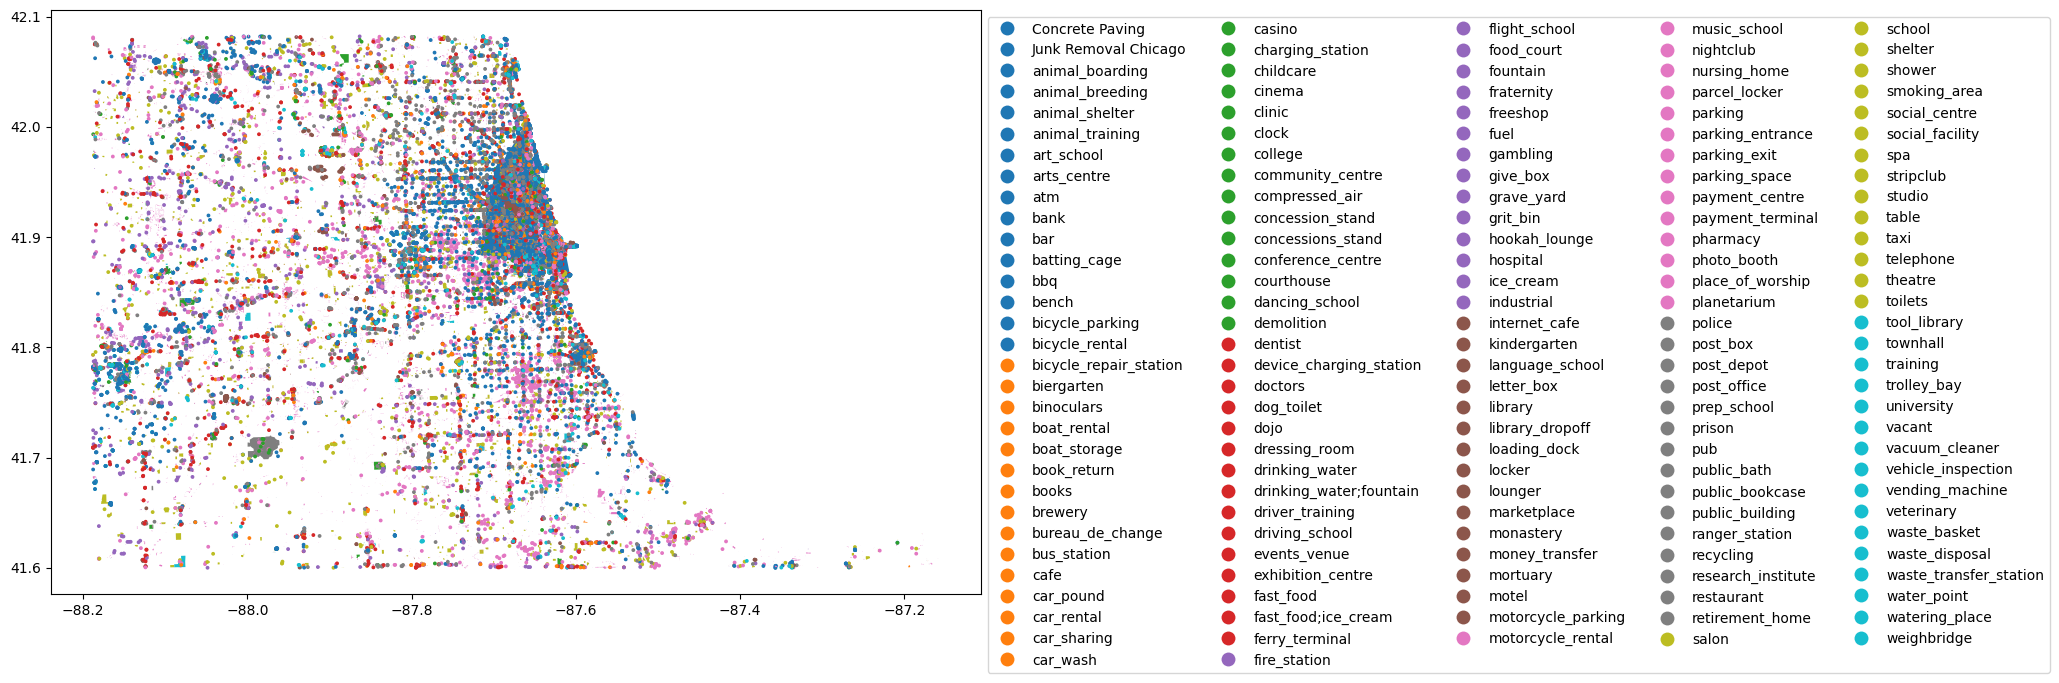

In [28]:
# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
custom_filter = {'amenity': True}
pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]

# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

childcare, clinic, community_centre, dentist, doctors, hospital, nursing_home, pharmacy

library, library_dropoff, kindergarden, language_school, flight_school, driving_school, dancing_school, college, bus_station, art_school, music_school, prep_school, public_building, research_institute, school, social_centre, social_facility, tool_library, university, veterinary

supported boundary -> "tract"

In [31]:
# Test reading all transit related data (bus, trains, trams, metro etc.)
# Exclude nodes (not keeping stops, etc.)
routes = ["bus", "ferry", "railway", "subway", "train", "tram", "trolleybus"]
rails = ["tramway", "light_rail", "rail", "subway", "tram"]
bus = ['yes']
transit = osm.get_data_by_custom_criteria(custom_filter={
                                        'route': routes,
                                        'railway': rails,
                                        'bus': bus,
                                        'public_transport': True},
                                        # Keep data matching the criteria above
                                        filter_type="keep",
                                        # Do not keep nodes (point data)    
                                        keep_nodes=True, 
                                        keep_ways=True, 
                                        keep_relations=True)

In [ ]:
transit.plot()

/Users/kirtisoglu/.local/share/virtualenvs/Allocation-of-Primary-Care-Centers-in-Chic-LgtmrD4y/lib/python3.12/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


<Axes: >

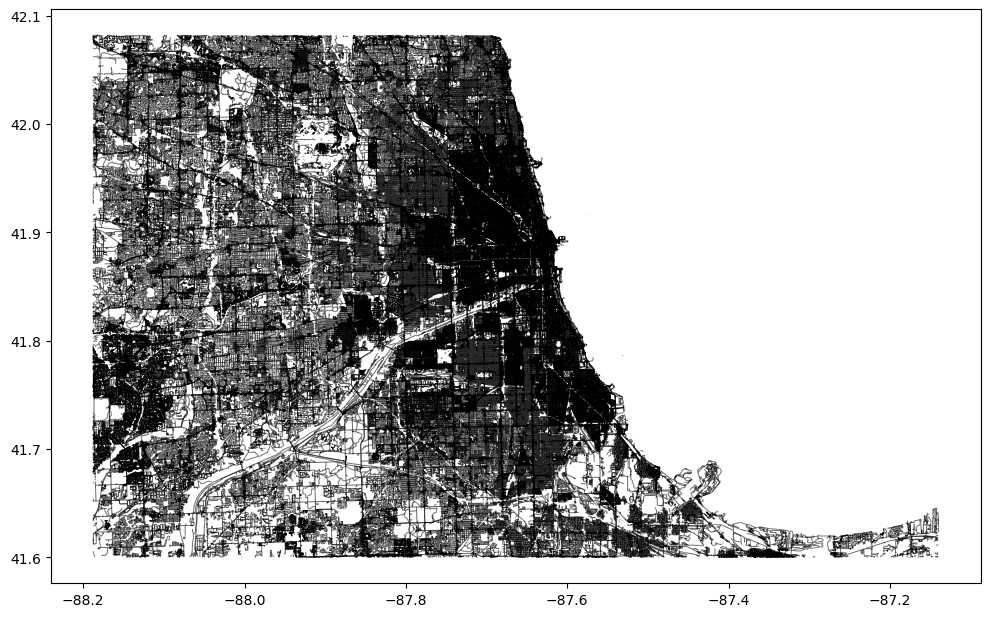

In [35]:
# Apply the same bounding box filter and retrieve walking network
walk = osm.get_network("walking")
walk.plot(color="k", figsize=(12,12), lw=0.7, alpha=0.6)

In [ ]:
# Show all available tag attributes
osm.conf.tags.available

# Show all tags that are converted into columns from building features
osm.conf.tags.building

# Parse buildings
buildings = osm.get_buildings()

# Print columns
buildings.columns

In [41]:
pois["school"]

0        None
1        None
2        None
3        None
4        None
         ... 
60766     NaN
60767     NaN
60768     NaN
60769     NaN
60770     NaN
Name: school, Length: 60771, dtype: object

In [ ]:
import osmnx as ox


polygon = ox.geocode_to_gdf("Chicago, Illinois, USA").loc[0, "geometry"]
poly_proj, crs_proj = ox.projection.project_geometry(polygon)
polygon, _ = ox.projection.project_geometry(poly_proj.buffer(1000), crs=crs_proj, to_latlong=True)
G = ox.graph_from_polygon(polygon, network_type="walk")

In [51]:
G.plot()

AttributeError: 'MultiDiGraph' object has no attribute 'plot'

# 1. Parse the GTFS data 

Partridge repo: https://github.com/remix/partridge

In [49]:
import partridge as ptg

path='/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/initial_data/google_transit.zip'


In [50]:
service_ids = ptg.read_busiest_date(path)[1]
view = {'trips.txt': {'service_id': service_ids}}

feed = ptg.load_geo_feed(path, view)

feed.shapes.head()

/Users/kirtisoglu/.local/share/virtualenvs/Allocation-of-Primary-Care-Centers-in-Chic-LgtmrD4y/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,shape_id,geometry
0,308300001,"LINESTRING (-87.81732 41.87426, -87.81591 41.8..."
1,308300002,"LINESTRING (-87.90422 41.97767, -87.90234 41.9..."
2,308300007,"LINESTRING (-87.67289 42.01906, -87.67232 42.0..."
3,308300008,"LINESTRING (-87.62441 41.72238, -87.62454 41.7..."
4,308300009,"LINESTRING (-87.66384 41.77895, -87.66156 41.7..."
